# vanZadelhoff benchmark: 2a

We run the benchmarking problems by van Zadelhoff et al. (2002) using Magritte.

## 0) Setup

In [1]:
# Define Magritte folders

MagritteSetupFolder = '/home/frederik/Dropbox/Astro/Magritte/modules/setup/'
ProjectFolder       = '/home/frederik/MagritteProjects/vanZadelhoff/problem_2/'

In [2]:
# Import tools and libraries

import numpy as np

from bokeh.plotting import figure, show, gridplot
from bokeh.palettes import cividis
from bokeh.io       import output_notebook, curdoc
output_notebook()
curdoc().theme = 'dark_minimal'

from glob       import glob
from sys        import path
path.insert(0, MagritteSetupFolder)

# Import from MagritteSetupFolder
from spheres  import deSphere, sphereVar, nRays
from lineData import LineData, planck, relativeDifference
from setup    import setupMagritte
from model    import mapToXD
from model    import model as Model

Loading BokehJS ...

## 1) Define model

Read model file provided on the benchmark [website](https://www.strw.leidenuniv.nl/astrochem/radtrans/).

In [3]:
# Read model data file
file_benchmark_model  = ProjectFolder + 'benchmark_models/model_1.d'
R, nh2, X_mol, T, VR, b = np.loadtxt(file_benchmark_model, skiprows=7, unpack=True)

# Convert cgs to SI units
R   = R   * 1.0E-2
nh2 = nh2 * 1.0E+6
VR  = VR  * 1.0E+3
b   = b   * 1.0E+3

# Put radii in ascending order
R     = np.flip (R,     axis=0)
nh2   = np.flip (nh2,   axis=0)
X_mol = np.flip (X_mol, axis=0)
T     = np.flip (T,     axis=0)
VR    = np.flip (VR,    axis=0)
b     = np.flip (b,     axis=0)

# Only use half of the grid points to speed up calculations
R     = R[::2]
nh2   = nh2[::2]
X_mol = X_mol[::2]
T     = T[::2]
VR    = VR[::2]
b     = b[::2]

In [4]:
# Setup model

model = Model (dim=1)

model.ncells = len(R)

model.x = R
model.y = [0.0 for _ in range(model.ncells)]
model.z = [0.0 for _ in range(model.ncells)]

model.vx = VR
model.vy = [0.0 for _ in range(model.ncells)]
model.vz = [0.0 for _ in range(model.ncells)]

model.density     = nh2
model.abundance   = X_mol * nh2
model.temperature = T
model.vturbulence = b

# Define nsidesList for mapping to 3D model
nraysList = [int(3+np.pi*np.log(i+1)) for i in range(model.ncells)]

# Map 1D model to spherically symmetric 2D model
(model2D, cellsInShell) = mapToXD(model, dimension=2, nraysList=nraysList)

#model2D.boundary = model2D.boundary + cellsInShell[0]

# Define rays
model2D.defineRays (nrays=50)

# Write new model data
model2D.writeInput (ProjectFolder + 'Magritte_files/')

# Run setup
setupMagritte (projectFolder = ProjectFolder, runName = '')

print(f'ncells in 2D model = {model2D.ncells}')
print(f'nrays  in 2D model = {model2D.nrays} ')

ncells in 2D model = 246
nrays  in 2D model = 50 


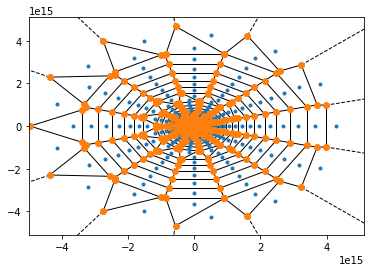

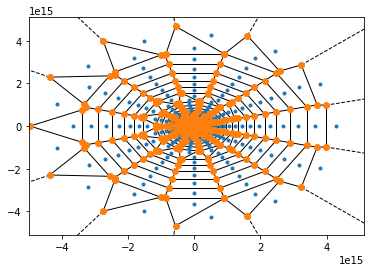

In [5]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
%matplotlib inline

points = [[model2D.x[p], model2D.y[p]] for p in range(model2D.ncells)]
vor    = Voronoi(points)

voronoi_plot_2d(vor)

### Plot model

In [6]:
plot_model_1 = figure (plot_width=400, plot_height=250, x_axis_type='log', y_axis_type='log')
plot_model_1.line (model.x, model.density)
plot_model_1.xaxis.axis_label = "x [m]"
plot_model_1.yaxis.axis_label = "density [m^-3]"

plot_model_2 = figure (plot_width=400, plot_height=250, x_axis_type='log', y_axis_type='log')
plot_model_2.line (model.x, model.abundance)
plot_model_2.xaxis.axis_label = "x [m]"
plot_model_2.yaxis.axis_label = "abundance [xm^-3]"

plot_model_3 = figure(plot_width=400, plot_height=250, x_axis_type='log')
plot_model_3.line (model.x, model.temperature)
plot_model_3.xaxis.axis_label = "x [m]"
plot_model_3.yaxis.axis_label = "temperature [K]"

plot_model_4 = figure(plot_width=400, plot_height=250, x_axis_type='log')
plot_model_4.line (model.x, model.vx)
plot_model_4.xaxis.axis_label = "x [m]"
plot_model_4.yaxis.axis_label = "velocity_x [m^-3]"

plot_model = gridplot ([[plot_model_1, plot_model_2],[plot_model_3, plot_model_4]])

show (plot_model)

### Get Magritte output

In [6]:
# Read Magritte output

ioFolders = glob(ProjectFolder + 'io/*/')
ioFolders.sort()

inputFolders  = [folder +  'input/' for folder in ioFolders]
outputFolders = [folder + 'output/' for folder in ioFolders]

lastOutput = outputFolders[-1]
lastInput  =  inputFolders[-1]

pops_files = glob(lastOutput + 'populations_0*.txt')
Jeff_files = glob(lastOutput + 'Jeff_0*.txt')
J_files    = glob(lastOutput + 'J_*.txt')
G_files    = glob(lastOutput + 'G_*.txt')
nu_files   = glob(lastOutput + 'frequencies_nu*.txt')
lnr_files  = glob(lastOutput + 'frequencies_line_nr*.txt')
eta_files  = glob(lastOutput + 'eta_0*.txt')
chi_files  = glob(lastOutput + 'chi_0*.txt')

pops_files.sort()
Jeff_files.sort()
eta_files.sort()
chi_files.sort()

pops_2D_data = [np.loadtxt(fileName) for fileName in pops_files]
Jeff_2D_data = [np.loadtxt(fileName) for fileName in Jeff_files]
J_2D_data    = [np.loadtxt(fileName) for fileName in J_files]
G_2D_data    = [np.loadtxt(fileName) for fileName in G_files]
nu_2D_data   = [np.loadtxt(fileName) for fileName in nu_files]
lnr_2D_data  = [np.loadtxt(fileName) for fileName in lnr_files]
eta_2D_data  = [np.loadtxt(fileName) for fileName in eta_files]
chi_2D_data  = [np.loadtxt(fileName) for fileName in chi_files]

# Import linedata
lineData = LineData (ProjectFolder + '/Magritte_files/linedata/hco+.dat')

### Map sphere to 1D model

In [7]:
# Map shpere to 1D model

pops_data = deSphere(cellsInShell, pops_2D_data)
pops_var  = sphereVar(cellsInShell, pops_2D_data)

J_data = deSphere(cellsInShell, J_2D_data)
J_var  = sphereVar(cellsInShell, J_2D_data)

G_data = deSphere(cellsInShell, G_2D_data)
G_var  = sphereVar(cellsInShell, G_2D_data)

#Jeff_data = deSphere(cellsInShell, Jeff_2D_data)
#Jeff_var  = sphereVar(cellsInShell, Jeff_2D_data)

nu_data = deSphere(cellsInShell, nu_2D_data)
nu_var  = sphereVar(cellsInShell, nu_2D_data)

#lnr_data = deSphere(cellsInShell, lnr_2D_data)
#lnr_var  = sphereVar(cellsInShell, lnr_2D_data)

#etaR   = deSphere(cellsInShell, eta_data)
#etaVar = sphereVar(cellsInShell, eta_data)

#chiR   = deSphere(cellsInShell, chi_data)
#chiVar = sphereVar(cellsInShell, chi_data)

for s in range(model.ncells):
    #print(f'pops_var  = {np.max(pops_var[0][s])}')
    #print(f'Jeff_var  = {np.max(Jeff_var[0][s])}')
    print(f'J_var     = {np.max(J_var[0][s])}')
    #print(f'nu_var    = {np.max(nu_var[0][s])}')
    #print(f'lnr_var   = {np.max(lnr_var[0][s])}')

#print(np.max(etaVar))
#print(np.max(chiVar))

J_var     = 0.01906296458891941
J_var     = 0.02097016644622931
J_var     = 0.01899220969328214
J_var     = 0.014548033837465817
J_var     = 0.013650172168438172
J_var     = 0.012990672506393767
J_var     = 0.011574196538567602
J_var     = 0.012486694418815955
J_var     = 0.014404235653827813
J_var     = 0.017998738889127668
J_var     = 0.011958942858816697
J_var     = 0.014215156122312911
J_var     = 0.010707600022163147
J_var     = 0.010867032732949457
J_var     = 0.010521594703358407
J_var     = 0.012416337422820178
J_var     = 0.011252511720530895
J_var     = 0.01139373094510148
J_var     = 0.01086291435565989
J_var     = 0.012774393808585237
J_var     = 0.0140301016665191
J_var     = 0.015285689153282907
J_var     = 0.02315584800842578
J_var     = 0.029305908478168847
J_var     = 0.027365036097059838


In [8]:
# Load Ratran results

data_ratran = np.loadtxt('/home/frederik/Codes/Ratran_copy/FrederiksExapmle/output/myTest.pop', skiprows=14)
x_ratran    = np.sqrt(data_ratran[:,1]*data_ratran[:,2]) *1.0E-2
pops_ratran = data_ratran[:,9:]

### Plot output

In [9]:
# Plot functions

def color(s):
    ns = int((s_max-s_min) / s_step + 1)
    es = int((s    -s_min) / s_step)
    return cividis(ns)[es]

def legend(s):
    return f'{s}'

def bokeh_log_plot(title, x, y, xlabel, ylabel):
    return

In [10]:
s_min  = 0
s_max  = model.ncells
s_step = 1

In [11]:
outNr = 0

In [15]:
# Level populations

plot = figure (title='Level populations', width=700, height=400, y_axis_type='log', x_axis_type='log')
x  = np.sqrt(np.power(model2D.x, 2) + np.power(model2D.y,2))
for i in range(6):##lineData.nlev):
    y = pops_2D_data[outNr][:,i] / model2D.abundance
    plot.line (x, y, color='red')
plot.xaxis.axis_label = "r [m]"
plot.yaxis.axis_label = "population [m^-3]"
show (plot)

In [16]:
# Level populations

plot = figure (title='Level populations', width=700, height=400, y_axis_type='log', x_axis_type='log')
x  = np.sqrt(np.power(model2D.x, 2) + np.power(model2D.y,2))
y = pops_2D_data[outNr][:,1] / pops_2D_data[outNr][:,0]
plot.line (x, y, color='red')
plot.xaxis.axis_label = "r [m]"
plot.yaxis.axis_label = "population [m^-3]"
show (plot)

In [17]:
# Level populations

plot = figure (title='Level populations', width=700, height=400, y_axis_type='log', x_axis_type='log')
x  = np.sqrt(np.power(model2D.x, 2) + np.power(model2D.y,2))
y1 = Jeff_2D_data[-1][:]
plot.circle (x, y1, color='red')
#plot.circle (x_ratran, pops_ratran[:,0], color='black')
#plot.circle (x_ratran, pops_ratran[:,1], color='black')
plot.xaxis.axis_label = "r [m]"
plot.yaxis.axis_label = "population [m^-3]"
show (plot)

RuntimeError: Columns need to be 1D (y is not)

In [26]:
# Level populations

plot = figure (title='Level populations', width=700, height=400, y_axis_type='log', x_axis_type='log')
x = model.x
y1 = pops_data[outNr][:,0]/model.abundance
y2 = pops_data[outNr][:,1]/model.abundance
plot.line (x, y1)
plot.line (x, y2)
plot.xaxis.axis_label = "r [m]"
plot.yaxis.axis_label = "population [m^-3]"
show (plot)

In [24]:
np.shape(pops_data)

(26, 50, 2)

In [27]:
# Mean intensity

plot = figure (title='Total mean intensity', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = range(lineData.nrad)
    y = Jeff_data[1][s]
    plot.circle(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "number of the transition"
plot.yaxis.axis_label = "mean intensity J [m^-3]"
show(plot)

NameError: name 'Jeff_data' is not defined

In [28]:
# Spectrum

plot = figure (title='Spectrum', width=700, height=500, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    x = nu_data[outNr][s]
    y =  J_data[outNr][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "frequencies [Hz]"
plot.yaxis.axis_label = "Mean intensity [W/m^2]"
show(plot)

In [29]:
# Flux (G) spectrum

plot = figure (title='Spectrum', width=700, height=500)
for s in range(s_min, s_max, s_step):
    x = nu_data[outNr][s]
    y =  G_data[outNr][s]
    plot.line(x, y, color=color(s), legend=legend(s))
plot.xaxis.axis_label = "frequencies [Hz]"
plot.yaxis.axis_label = "Mean intensity [W/m^2]"
show(plot)

## Analytical solution

In [38]:
line = 0

In [39]:
# Analytical model

import scipy.integrate as integrate

# Constants

c     = 2.99792458E+8    # [m/s] speed of light
kb    = 1.38064852E-23   # [J/K] Boltzmann's constant
mp    = 1.6726219E-27    # [kg] proton mass
T_CMB = 2.7254800        # [K] CMB temperature
a     = 150.0            # [m/s]

pops       = lineData.LTEpop(T) * X_mol * n_H2
emissivity = lineData.lineEmissivity(pops)
opacity    = lineData.lineOpacity(pops)
source     = emissivity / opacity

def bcd (nu):
    return planck(T_CMB, nu)

S     = source[line]
chi   = opacity[line]
R     = model.x[-1]
v_max = model.vx[-1]
nuij  = lineData.frequency[line]
dnu   = nuij/c * a

def phi(nu):
    return 1 / (np.sqrt(np.pi) * dnu) * np.exp(-((nu-nuij)/dnu)**2)

def z_max(r, theta):
    return r * np.cos(theta) + np.sqrt(R**2 - (r*np.sin(theta))**2)

def tau(nu, r, theta):
    factor = np.arctan( (r+z_max(r, theta)) / (r-z_max(r,theta)) * np.tan(theta/2) )
    factor = factor - theta/2
    return chi * phi(nu) * n_H2 * r_in**2 * factor / (r*np.sin(theta))

def J(nu, r):
    B = bcd (nu)
    return S + (B-S) / np.pi * integrate.quad (lambda theta: np.exp(-tau(nu, r, theta)), 0, np.pi)[0]

In [40]:
a/c

5.00346142797228e-07

Assuming boundary condition $B_{\nu}$ on both sides of the ray, the intensity is given by

\begin{align}
I^{+}_{\nu}(x) \ &= \ B_{\nu} e^{-\tau_{\nu'}(0,x)} + \int_{0}^{x} \text{d}x' \ \eta_{\nu'}(x') \ e^{-\tau_{\nu'}(x', x)} \\
I^{-}_{\nu}(x) \ &= \ B_{\nu} e^{-\tau_{\nu'}(x,L)} + \int_{x}^{L} \text{d}x' \ \eta_{\nu'}(x') \ e^{-\tau_{\nu'}(x, x')}
\end{align}

where the optical depth $\tau^{\pm}_{\nu}$ is defined

\begin{equation}
    \tau_{\nu}(x_{1}, x_{2}) \ = \ \int_{x_{1}}^{x_{2}} \text{d} x' \ \chi_{\nu}(x') .
\end{equation}

The mean intensity is hence given by

\begin{equation}
    J_{\nu}(x) \ = \ \frac{1}{2} \big( I^{+}_{\nu}(x) \ + \ I^{-}_{\nu}(x) \big)
\end{equation}

The frequency dependence of the emissivity and opacity only comes from the line profile

\begin{align}
    \eta_{\nu}(x) \ &= \ \eta_{ij} \phi_{\nu}, \\
    \chi_{\nu}(x) \ &= \ \chi_{ij} \phi_{\nu},
\end{align}

where we assume a Gaussian profile

\begin{equation}
	\phi_{\nu}^{ij}(x) \ = \ \frac{1}{\sqrt{\pi} \ \delta\nu_{ij}(x)} \ \exp \left[-\left(\frac{\nu-\nu_{ij}} {\delta\nu_{ij}(x)}\right)^{2}\right], \hspace{5mm} \text{where} \hspace{5mm} \delta\nu_{ij}(x) \ = \ \frac{\nu_{ij}}{c} \sqrt{ \frac{2 k_{b} T(x)}{m_{\text{spec}}} \ + \ v_{\text{turb}}^{2}(x)}.
\end{equation}

Solving the integral for the optical depth then yields

\begin{equation}
  \tau^{\pm}_{\nu}(x) \ = \ \frac{\chi}{\sqrt{\pi}} \ \int_{0}^{\ell} \text{d} l \ \frac{1}{\delta\nu_{ij}(x \pm l)} \ \exp \left[-\left(\frac{\nu-\nu_{ij}} {\delta\nu_{ij}(x \pm l)}\right)^{2}\right] .
\end{equation}

In [17]:
def relativeError(a,b):
    return 2.0 * np.abs((a-b)/(a+b))

In [18]:
# Line

plot_model = figure(title='Line model', width=400, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    # model
    x = nuij + 8 * dnu * np.linspace(-1,1,500)
    y = [J(xi, model.x[s]) for xi in x]
    plot_model.line(x, y, color=color(s))
    # data
    x = nu_data[0][s]
    y =  J_data[0][s]
    plot_model.circle(x, y, color=color(s), legend=legend(s))

errors = np.zeros(model.ncells)
    
plot_error = figure(title='Line error', width=400, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    # error
    x = nu_data[0][s]
    y = relativeError([J(xi, model.x[s]) for xi in x], J_data[0][s])
    errors[s] = np.max(y)
    plot_error.circle(x, y, color=color(s), legend=legend(s))

plot = gridplot([[plot_model, plot_error]])

show(plot)

NameError: name 'nuij' is not defined